In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')
pd.pandas.set_option('display.max_columns',0)

In [4]:
df=pd.read_csv('yellow_tripdata_2023-01.csv',low_memory=False)

In [5]:
df.sample(3)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
2578188,2,2023-01-27 17:41:12,2023-01-27 17:53:54,1.0,1.35,1.0,N,237,142,1,12.8,2.5,0.5,1.25,0.0,1.0,20.55,2.5,0.0
735851,2,2023-01-09 14:50:55,2023-01-09 15:05:13,2.0,2.02,1.0,N,232,249,1,14.9,0.0,0.5,2.0,0.0,1.0,20.9,2.5,0.0
1322747,2,2023-01-15 01:57:21,2023-01-15 02:21:30,2.0,6.92,1.0,N,114,24,1,33.1,1.0,0.5,7.62,0.0,1.0,45.72,2.5,0.0


In [6]:
#total number of rows and column (3066812, 19)
df.shape

(3066812, 19)

In [7]:
#Check null value in all column
df.isnull().sum()

VendorID                     0
tpep_pickup_datetime         0
tpep_dropoff_datetime        0
passenger_count          71743
trip_distance                0
RatecodeID               71743
store_and_fwd_flag       71743
PULocationID                 0
DOLocationID                 0
payment_type                 0
fare_amount                  0
extra                        0
mta_tax                      0
tip_amount                   0
tolls_amount                 0
improvement_surcharge        0
total_amount                 0
congestion_surcharge     71743
airport_fee              71743
dtype: int64

In [9]:
#Check distinct value in PULocationID and DOLocationID column
print(df['passenger_count'].isnull().sum())

71743


## passenger_count, RatecodeID, store_and_fwd_flag, congestion_surcharge and airport_fee column has 71743 records of null value.

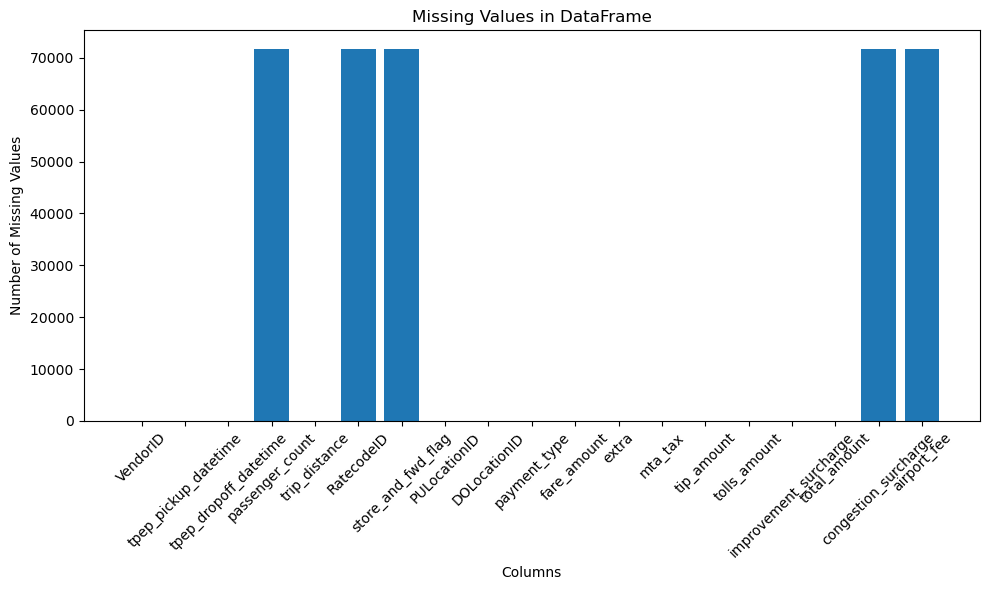

In [8]:
#Plot null value count with column

# Assuming df is your DataFrame
missing_values = df.isnull().sum()

# Creating a bar plot using Matplotlib
plt.figure(figsize=(10, 6))
plt.bar(missing_values.index, missing_values.values)
plt.title('Missing Values in DataFrame')
plt.xlabel('Columns')
plt.ylabel('Number of Missing Values')
plt.xticks(rotation=45)  # Rotating x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()


In [9]:
#Check the data types of all present column in df dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3066812 entries, 0 to 3066811
Data columns (total 19 columns):
 #   Column                 Dtype 
---  ------                 ----- 
 0   VendorID               object
 1   tpep_pickup_datetime   object
 2   tpep_dropoff_datetime  object
 3   passenger_count        object
 4   trip_distance          object
 5   RatecodeID             object
 6   store_and_fwd_flag     object
 7   PULocationID           object
 8   DOLocationID           object
 9   payment_type           object
 10  fare_amount            object
 11  extra                  object
 12  mta_tax                object
 13  tip_amount             object
 14  tolls_amount           object
 15  improvement_surcharge  object
 16  total_amount           object
 17  congestion_surcharge   object
 18  airport_fee            object
dtypes: object(19)
memory usage: 444.6+ MB


In [10]:
distinct_count = len(df['VendorID'].unique())
print("Distinct value in VendorID column",df['VendorID'].unique())
print("Count of distinct values in 'VendorID' column:", distinct_count)

Distinct value in VendorID column ['2' '1' 'VendorID']
Count of distinct values in 'VendorID' column: 3


### For data better understanding let's load the both csv file in postgresql database but this is completely optional we can do all the data preparation part using pandas.

In [15]:
import psycopg2
import pandas as pd
from psycopg2 import extras

try:
    # Establishing the connection
    conn = psycopg2.connect(
        database="postgres", user='postgres', password='password', host='127.0.0.1', port='5432')
    
    # Creating a cursor object using the cursor() method
    cursor = conn.cursor()
    
    # Create table yellow_tripdata_2023_01 if not exists
    cursor.execute('''CREATE TABLE IF NOT EXISTS yellow_tripdata_2023_01 (
                            id SERIAL PRIMARY KEY,
                            VendorID TEXT, 
                            tpep_pickup_datetime TEXT,
                            tpep_dropoff_datetime TEXT,
                            passenger_count TEXT,
                            trip_distance TEXT,
                            RatecodeID TEXT,
                            store_and_fwd_flag TEXT,
                            PULocationID TEXT,
                            DOLocationID TEXT,
                            payment_type TEXT,
                            fare_amount TEXT,
                            extra TEXT,
                            mta_tax TEXT,
                            tip_amount TEXT,
                            tolls_amount TEXT,
                            improvement_surcharge TEXT,
                            total_amount TEXT,
                            congestion_surcharge TEXT,
                            airport_fee TEXT);''')
    
    # Commit the table creation
    conn.commit()
    print("Table 'yellow_tripdata_2023_01' created successfully")
    
    # Load CSV file into a DataFrame skipping the header row
    df = pd.read_csv('yellow_tripdata_2023-01.csv', low_memory=False) 
    
    # Prepare data as a list of tuples
    data = [tuple(row) for row in df.itertuples(index=False, name=None)]
    
    # Construct the INSERT INTO statement
    insert_query = """
        INSERT INTO yellow_tripdata_2023_01 (VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, 
        trip_distance, RatecodeID, store_and_fwd_flag, PULocationID, DOLocationID, payment_type, fare_amount, extra, 
        mta_tax, tip_amount, tolls_amount, improvement_surcharge, total_amount, congestion_surcharge, airport_fee)
        VALUES %s
    """
    
    # Execute the INSERT INTO statement using execute_values()
    extras.execute_values(cursor, insert_query, data, page_size=100000) #page_size is number of rows to be inserted  
    
    # Committing the transaction
    conn.commit()
    print("Data inserted successfully in yellow_tripdata_2023_01 table")
    
    
    # Create table taxi_zones if not exists
    cursor.execute('''create table taxi_zones(OBJECTID int PRIMARY KEY,
                                                    Shape_Leng float,
                                                    the_geom text,
                                                    Shape_Area float,
                                                    Zone text,
                                                    LocationID int,
                                                    Borough text);''')
    

    # Commit the table creation
    conn.commit()
    
    print("Table 'taxi_zones' created successfully")

    # Load CSV file into a DataFrame skipping the header row
    zone_df = pd.read_csv('/home/bibek/Desktop/uber_data_engineering/data/taxi_zones.csv', low_memory=False) 
    
    # Prepare data as a list of tuples
    zone_data = [tuple(row) for row in zone_df.itertuples(index=False, name=None)]
    
    # Construct the INSERT INTO statement
    zone_insert_query = """
        INSERT INTO taxi_zones (OBJECTID,Shape_Leng,the_geom,Shape_Area,Zone,LocationID,Borough)
        VALUES %s
    """
    
    # Execute the INSERT INTO statement using execute_values()
    extras.execute_values(cursor, zone_insert_query, zone_data, page_size=1000) #page_size is number of rows to be inserted  
    
    # Committing the transaction
    conn.commit()
    print("Data inserted successfully in taxi_zones table")

except (Exception, psycopg2.Error) as error:
    print("Error while connecting to PostgreSQL or inserting data:", error)

finally:
    # Closing the connection
    if conn:
        cursor.close()
        conn.close()
        print("PostgreSQL connection is closed")

Table 'yellow_tripdata_2023_01' created successfully
Data inserted successfully in yellow_tripdata_2023_01 table
Table 'taxi_zones' created successfully
Data inserted successfully in taxi_zones table
PostgreSQL connection is closed


In [16]:
from IPython.display import Image

# Use the raw URL of the image
image_url = "https://raw.githubusercontent.com/bibek376/Uber_Data_Engineering_Project/master/pictures/1.png"

# Display the image
Image(url=image_url)


In [17]:
#only garbage data
filtered_df = df[df['VendorID'] == 'VendorID']

In [19]:
#verify them by selecting random value
filtered_df.sample(5)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
666689,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
3000104,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
2133407,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
1333379,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
1933400,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee


In [20]:
#calculate total number of garabge rows in csv file
filtered_df.shape

(46, 19)

In [21]:
#Select only the proper data
after_filtered_df=df[df['VendorID'] != 'VendorID']

#### According to data dictionary VendorID, RatecodeID, store_and_fwd_flag and payment_type are the categorical data

In [22]:
after_filtered_df['VendorID']=after_filtered_df['VendorID'].astype('category')
after_filtered_df['tpep_pickup_datetime']=pd.to_datetime(after_filtered_df['tpep_pickup_datetime'])
after_filtered_df['tpep_dropoff_datetime']=pd.to_datetime(after_filtered_df['tpep_dropoff_datetime'])
after_filtered_df['passenger_count']=pd.to_numeric(after_filtered_df['passenger_count'],downcast='integer')
after_filtered_df['trip_distance']=pd.to_numeric(after_filtered_df['trip_distance'])
after_filtered_df['RatecodeID']=after_filtered_df['RatecodeID'].astype('category')
after_filtered_df['store_and_fwd_flag']=after_filtered_df['store_and_fwd_flag'].astype('category')
after_filtered_df['PULocationID']=pd.to_numeric(after_filtered_df['PULocationID'])
after_filtered_df['DOLocationID']=pd.to_numeric(after_filtered_df['DOLocationID'])
after_filtered_df['payment_type']=after_filtered_df['payment_type'].astype('category')
after_filtered_df['fare_amount']=pd.to_numeric(after_filtered_df['fare_amount'])
after_filtered_df['extra']=pd.to_numeric(after_filtered_df['extra'])
after_filtered_df['mta_tax']=pd.to_numeric(after_filtered_df['mta_tax'])
after_filtered_df['tip_amount']=pd.to_numeric(after_filtered_df['tip_amount'])
after_filtered_df['tolls_amount']=pd.to_numeric(after_filtered_df['tolls_amount'])
after_filtered_df['improvement_surcharge']=pd.to_numeric(after_filtered_df['improvement_surcharge'])
after_filtered_df['total_amount']=pd.to_numeric(after_filtered_df['total_amount'])
after_filtered_df['congestion_surcharge']=pd.to_numeric(after_filtered_df['congestion_surcharge'])
after_filtered_df['airport_fee']=pd.to_numeric(after_filtered_df['airport_fee'])

In [23]:
#Check data type conversion
after_filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3066766 entries, 0 to 3066811
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               category      
 1   tpep_pickup_datetime   datetime64[ns]
 2   tpep_dropoff_datetime  datetime64[ns]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             category      
 6   store_and_fwd_flag     category      
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           category      
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  airport_fee            floa

### check if there is same value in tpep_pickup_datetime and tpep_dropoff_datetime: if there is same value logically data is not useful

In [27]:
df = df[df['tpep_dropoff_datetime'] != 'tpep_dropoff_datetime']

In [28]:
df['VendorID']=pd.to_numeric(df['VendorID'],downcast='integer')
df['tpep_pickup_datetime']=pd.to_datetime(df['tpep_pickup_datetime'])
df['tpep_dropoff_datetime']=pd.to_datetime(df['tpep_dropoff_datetime'])
df['passenger_count']=pd.to_numeric(df['passenger_count'],downcast='integer')

In [ ]:
df['trip_distance']=pd.to_datetime(df['trip_distance'])
df['RatecodeID']=pd.to_datetime(df['RatecodeID'])
df['store_and_fwd_flag']=pd.to_datetime(df['store_and_fwd_flag'])
df['PULocationID']=pd.to_datetime(df['PULocationID'])
df['DOLocationID']=pd.to_datetime(df['DOLocationID'])
df['payment_type']=pd.to_datetime(df['payment_type'])
df['fare_amount']=pd.to_datetime(df['fare_amount'])
df['extra']=pd.to_datetime(df['extra'])
df['mta_tax']=pd.to_datetime(df['mta_tax'])
df['tip_amount']=pd.to_datetime(df['tip_amount'])
df['tolls_amount']=pd.to_datetime(df['tolls_amount'])
df['improvement_surcharge']=pd.to_datetime(df['improvement_surcharge'])
df['total_amount']=pd.to_datetime(df['total_amount'])
df['congestion_surcharge']=pd.to_datetime(df['congestion_surcharge'])
df['airport_fee']=pd.to_datetime(df['airport_fee'])

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3066766 entries, 0 to 3066811
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int8          
 1   tpep_pickup_datetime   datetime64[ns]
 2   tpep_dropoff_datetime  datetime64[ns]
 3   passenger_count        float64       
 4   trip_distance          object        
 5   RatecodeID             object        
 6   store_and_fwd_flag     object        
 7   PULocationID           object        
 8   DOLocationID           object        
 9   payment_type           object        
 10  fare_amount            object        
 11  extra                  object        
 12  mta_tax                object        
 13  tip_amount             object        
 14  tolls_amount           object        
 15  improvement_surcharge  object        
 16  total_amount           object        
 17  congestion_surcharge   object        
 18  airport_fee            obje

Load both file in postgreSQL datbase for data cleaning 

In [12]:
df_test = pd.read_csv('yellow_tripdata_2023-01.csv', skiprows=1)

/tmp/ipykernel_17998/4041931336.py:1: DtypeWarning: Columns (0,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df_test = pd.read_csv('yellow_tripdata_2023-01.csv', skiprows=1)


In [13]:
df_test.sample(4)

,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0.1,N,161,141,2.1,9.3,1.0.2,0.5,0.0,0.0.1,1.0.3,14.3,2.5,0.0.2
63888,2,2023-01-01 20:37:14,2023-01-01 20:45:27,1.0,2.21,1.0,N,142,151,1,12.1,1.0,0.5,3.42,0.0,1.0,20.52,2.5,0.0
2105760,2,2023-01-23 05:33:06,2023-01-23 05:38:51,2.0,1.24,1.0,N,186,233,1,8.6,1.0,0.5,2.72,0.0,1.0,16.32,2.5,0.0
2337212,2,2023-01-25 14:57:51,2023-01-25 15:08:43,1.0,2.87,1.0,Y,233,232,1,15.6,0.0,0.5,5.88,0.0,1.0,25.48,2.5,0.0
2468569,2,2023-01-26 17:05:10,2023-01-26 17:57:30,1.0,11.48,1.0,N,142,181,1,57.6,2.5,0.5,10.0,6.55,1.0,80.65,2.5,0.0


In [14]:
for index, row in df.iterrows():
    print(f"Index: {index}")
    print(f"Row data:\n{row}\n")
    break;

Index: 0
Row data:
VendorID                                   2
tpep_pickup_datetime     2023-01-01 00:32:10
tpep_dropoff_datetime    2023-01-01 00:40:36
passenger_count                          1.0
trip_distance                           0.97
RatecodeID                               1.0
store_and_fwd_flag                         N
PULocationID                             161
DOLocationID                             141
payment_type                               2
fare_amount                              9.3
extra                                    1.0
mta_tax                                  0.5
tip_amount                               0.0
tolls_amount                             0.0
improvement_surcharge                    1.0
total_amount                            14.3
congestion_surcharge                     2.5
airport_fee                              0.0
Name: 0, dtype: object



In [72]:
# #Insert all the csv data into tables
# import psycopg2
# import pandas as pd
# from psycopg2 import extras

# try:
#     # Establishing the connection
#     conn = psycopg2.connect(
#         database="postgres", user='postgres', password='password', host='127.0.0.1', port='5432')
    
#     # Creating a cursor object using the cursor() method
#     cursor = conn.cursor()
    
#     # Load CSV file into a DataFrame skipping the header row
#     df = pd.read_csv('yellow_tripdata_2023-01.csv', skiprows=1,low_memory=False)  # Adjust the file path as necessary
    
#     # Insert DataFrame records into PostgreSQL table
#     for index, row in df.iterrows():
#         cursor.execute("""
#             INSERT INTO yellow_tripdata_2023_01 (VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, 
#             trip_distance, RatecodeID, store_and_fwd_flag, PULocationID, DOLocationID, payment_type, fare_amount, extra, 
#             mta_tax, tip_amount, tolls_amount, improvement_surcharge, total_amount, congestion_surcharge, airport_fee)
#             VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
#         """, tuple(row))

#         # Committing the transaction
#         conn.commit()
#     print("Data inserted successfully")

# except(Exception, psycopg2.Error) as error:
#     print("Error while connecting to PostgreSQL", error)

# finally:
#     # Closing the connection
#     if conn:
#         cursor.close()
#         conn.close()
#         print("PostgreSQL connection is closed")


Table creation and Data insertation at a time.

In [15]:
# import psycopg2
# import pandas as pd
# from psycopg2 import extras

# try:
#     # Establishing the connection
#     conn = psycopg2.connect(
#         database="postgres", user='postgres', password='password', host='127.0.0.1', port='5432')
    
#     # Creating a cursor object using the cursor() method
#     cursor = conn.cursor()
    
#     # Create table if not exists
#     cursor.execute('''CREATE TABLE IF NOT EXISTS yellow_tripdata_2023_01 (
#                             id SERIAL PRIMARY KEY,
#                             VendorID TEXT, 
#                             tpep_pickup_datetime TEXT,
#                             tpep_dropoff_datetime TEXT,
#                             passenger_count TEXT,
#                             trip_distance TEXT,
#                             RatecodeID TEXT,
#                             store_and_fwd_flag TEXT,
#                             PULocationID TEXT,
#                             DOLocationID TEXT,
#                             payment_type TEXT,
#                             fare_amount TEXT,
#                             extra TEXT,
#                             mta_tax TEXT,
#                             tip_amount TEXT,
#                             tolls_amount TEXT,
#                             improvement_surcharge TEXT,
#                             total_amount TEXT,
#                             congestion_surcharge TEXT,
#                             airport_fee TEXT);''')
    
#     # Commit the table creation
#     conn.commit()
#     print("Table 'yellow_tripdata_2023_01' created successfully")
    
#     # Load CSV file into a DataFrame skipping the header row
#     df = pd.read_csv('yellow_tripdata_2023-01.csv', skiprows=1, low_memory=False) 
    
#     # Prepare data as a list of tuples
#     data = [tuple(row) for row in df.itertuples(index=False, name=None)]
    
#     # Construct the INSERT INTO statement
#     insert_query = """
#         INSERT INTO yellow_tripdata_2023_01 (VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, 
#         trip_distance, RatecodeID, store_and_fwd_flag, PULocationID, DOLocationID, payment_type, fare_amount, extra, 
#         mta_tax, tip_amount, tolls_amount, improvement_surcharge, total_amount, congestion_surcharge, airport_fee)
#         VALUES %s
#     """
    
#     # Execute the INSERT INTO statement using execute_values()
#     extras.execute_values(cursor, insert_query, data, page_size=100000) #page_size is number of rows to be inserted  
    
#     # Committing the transaction
#     conn.commit()
#     print("Data inserted successfully")

# except (Exception, psycopg2.Error) as error:
#     print("Error while connecting to PostgreSQL or inserting data:", error)

# finally:
#     # Closing the connection
#     if conn:
#         cursor.close()
#         conn.close()
#         print("PostgreSQL connection is closed")


Table 'yellow_tripdata_2023_01' created successfully
Data inserted successfully
PostgreSQL connection is closed


In [25]:
taxi_zone_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 263 entries, 0 to 262
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   OBJECTID    263 non-null    int64  
 1   Shape_Leng  263 non-null    float64
 2   the_geom    263 non-null    object 
 3   Shape_Area  263 non-null    float64
 4   zone        263 non-null    object 
 5   LocationID  263 non-null    int64  
 6   borough     263 non-null    object 
dtypes: float64(2), int64(2), object(3)
memory usage: 14.5+ KB
